# Punkter i Planet

Nå er det på tide å sy sammen alle delene og se hvordan vi kan kaste store mengder data og regnekraft på en enkle og "dum" modell, og få noe som gjenskaper den underliggende sannheten.

In [1]:
%run funksjonalitet.ipynb
# Dette ligner "import", bare at vi henter definisjoner fra en Jupyter-notebook.

In [2]:
from spirals import get_data_spiral_2d

# Choose some parameters for the model:
K = 15 # Number of layers.
width = 2 # Width of each layer.
h = 0.1 # stepsize through layers.
model = Model(K, width, h)

numpoints = 1000  # Number of data points in tranining set.
Y0, C = get_data_spiral_2d(numpoints)
test_data, test_labels = get_data_spiral_2d(200)

maxiter = 10000  # number of iterations in optimization.
𝜏 = 0.1 # stepsize in descent search.
optimizer1 = PlainNonBatch(model, Y0, C, test_data, test_labels, maxiter, 𝜏)
optimizer1.run()


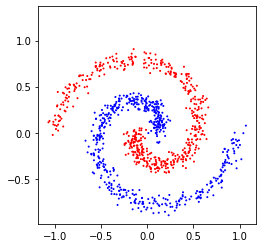

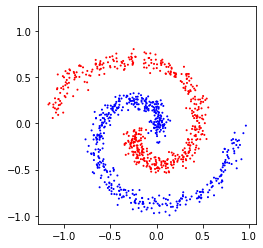

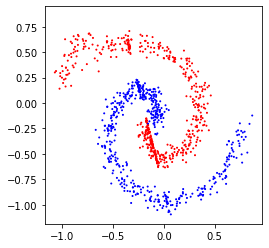

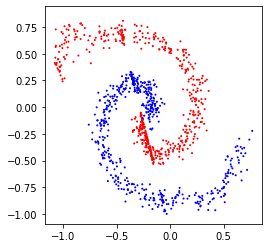

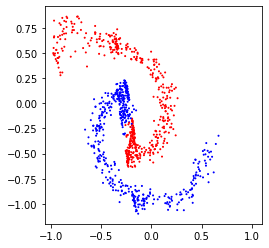

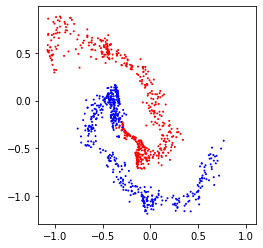

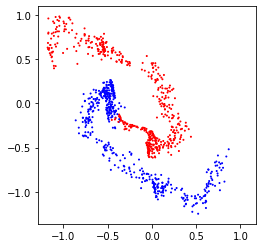

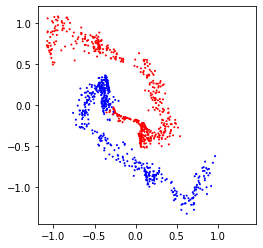

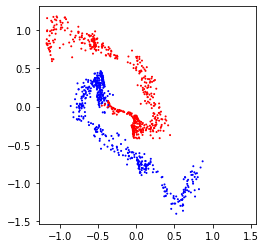

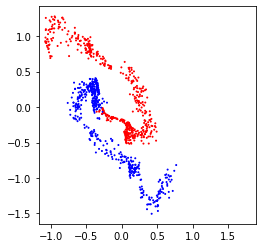

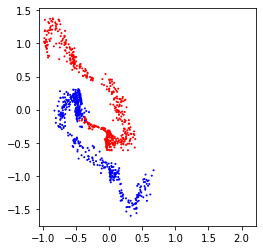

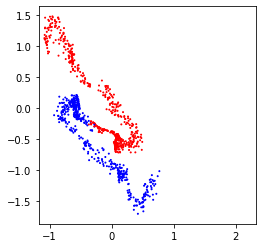

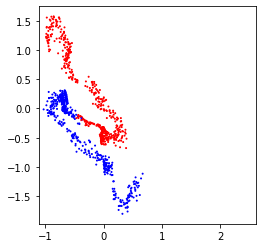

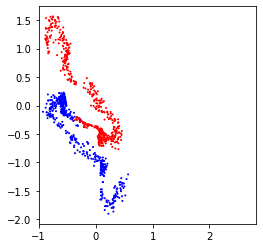

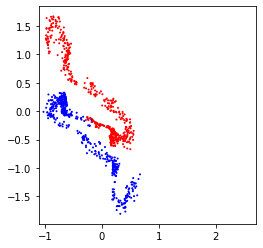

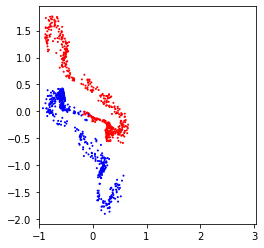

In [3]:
%matplotlib inline
from plotting import plot_progression

plot_progression(optimizer1.Y, optimizer1.C)

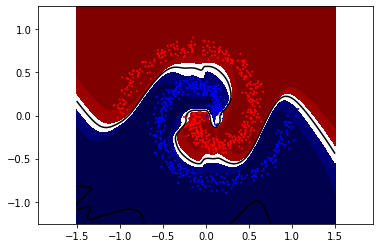

In [4]:
from plotting import plot_model

plot_model(optimizer1.model.fast_forward, optimizer1.training_data[:,:], optimizer1.training_labels, n=400)

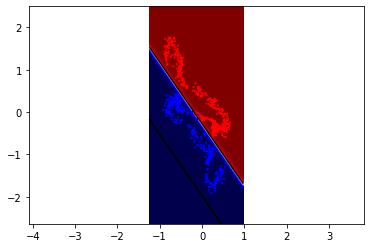

In [5]:
from plotting import plot_separation

plot_separation(optimizer1.model.fast_landscape, optimizer1.Y[-1,:,:], optimizer1.C, n=400)

# Lagring
I Python kan man lett lagre et helt objekt til fil med pakken pickle. Pickle er veldig enkel, og hvis du gjør selv en liten endring i klassedefinisjonen, kan det hende at det blir umulig å laste inn igjen dataene. Pickle er derfor ikke egnet for lagring over tid (dager og måneder). 

In [6]:
import pickle

with open('modelfile', mode='wb') as f:
    pickle.dump(optimizer1.model, f)

with open('modelfile', mode='rb') as f:
    model2 = pickle.load(f)


# Optimering

La oss ta en titt på de andre treningsalgoritmene:

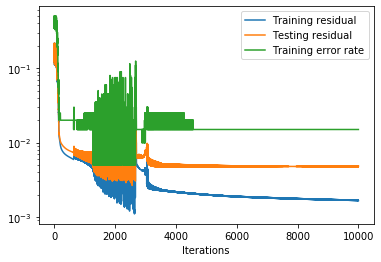

In [7]:
%matplotlib inline
plot_convergence(optimizer1)

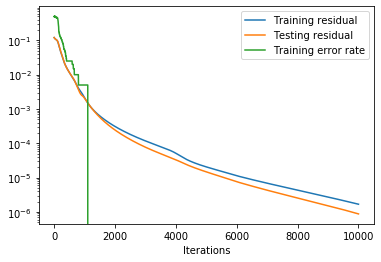

In [8]:
model = Model(K, width, h)
optimizer2 = AdamNonBatch(model, Y0, C, test_data, test_labels, maxiter)
optimizer2.run()

plot_convergence(optimizer2)

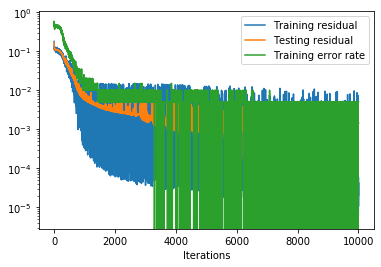

In [9]:
model = Model(K, width, h)
optimizer3 = PlainBatch(model, Y0, C, test_data, test_labels, maxiter, 𝜏, 100)
optimizer3.run()

plot_convergence(optimizer3)

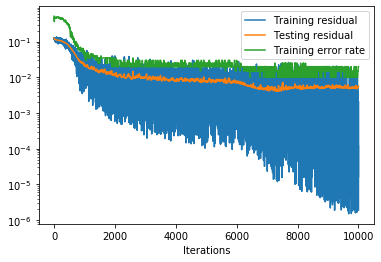

In [10]:
model = Model(K, width, h)
optimizer4 = AdamBatch(model, Y0, C, test_data, test_labels, maxiter, 50)
optimizer4.run()

plot_convergence(optimizer4)

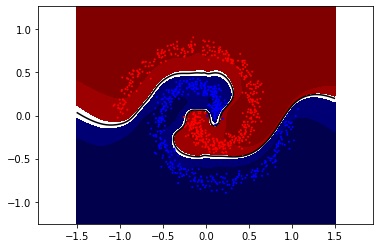

In [11]:
plot_model(optimizer4.model.fast_forward, optimizer4.training_data[:,:], optimizer4.training_labels, n=400)

La oss se hva som skjer når vi øker mengden treningsdata betydelig. Nedenfor lager vi 500 000 punkter og trener dem i batcher á 20 000.

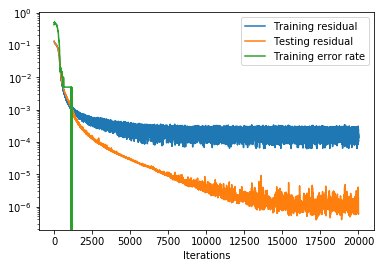

In [12]:
Y0, C = get_data_spiral_2d(500000)
model = Model(K, width, h)
optimizer5 = AdamBatch(model, Y0, C, test_data, test_labels, 20000, 20000)
optimizer5.run()

plot_convergence(optimizer5)

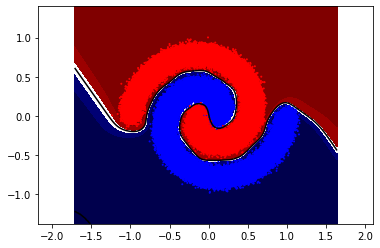

In [13]:
plot_model(optimizer5.model.fast_forward, optimizer5.training_data[:,:], optimizer5.training_labels, n=400)

Er dette egentlig en god modell?

# Metaparametre

Det er en del parametre som IKKE optimeres i algoritmen vår. Vi kan selvfølgelig forsøke å finne optimale verdier for disse også. Nedenfor velger vi en enkel tilnærming, vi varierer én variabel av gangen og ser hvor liten residualen på test-settet er etter 10 000 iterasjoner. Problemet med denne typen forsøk, er at det tar lang tid.

Vi begynner med 𝜏, den såkalte 'læringsraten'.
For akurat denne kan vi si noe om hvordan den kan forventes å avhenge av andre parametre.
Hvis vi bruker en bedre gradient, f.eks. ved å ha store batcher eller Adam metoden,
er det grunn til å håpe at vi kan ta større skritt.

In [14]:
# Choose some parameters for the model:
K = 15 # Number of layers.
width = 2 # Width of each layer.
h = 0.25 # stepsize through layers.


numpoints = 1000  # Number of data points in tranining set.
Y0, C = get_data_spiral_2d(numpoints)
test_data, test_labels = get_data_spiral_2d(200)

maxiter = 10000  # number of iterations in optimization.

𝜏s = np.logspace(-3.5, 0.5, num = 30) # stepsize in descent search.
results = []
for i, 𝜏 in enumerate(𝜏s):
    model = Model(K, width, h)
    op = PlainNonBatch(model, Y0, C, test_data, test_labels, maxiter, 𝜏)
    op.run()
    results.append(op.testing_residuals[-1])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


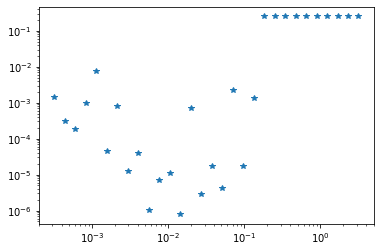

In [15]:
import matplotlib.pyplot as plt

plt.loglog(𝜏s, np.array(results), '*')
plt.show()

Deretter undersøker vi $h$, som sier noe om hvor mye hvert lag i nettverket vårt maksimalt kan gjøre.

In [16]:
# Choose some parameters for the model:
K = 15 # Number of layers.
width = 2 # Width of each layer.
#h = 0.1 # stepsize through layers.


numpoints = 1000  # Number of data points in tranining set.
Y0, C = get_data_spiral_2d(numpoints)
test_data, test_labels = get_data_spiral_2d(200)

maxiter = 10000  # number of iterations in optimization.
𝜏 = 0.01 # stepsize in descent search.

hs = np.logspace(-2, 0, num = 15)
results_hs = []
for i, h in enumerate(hs):
    model = Model(K, width, h)
    op = PlainNonBatch(model, Y0, C, test_data, test_labels, maxiter, 𝜏)
    op.run()
    results_hs.append(op.testing_residuals[-1])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


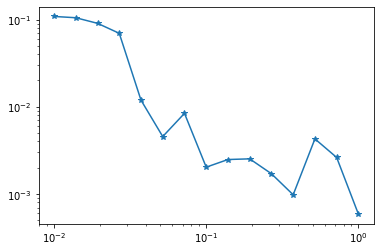

In [17]:
import matplotlib.pyplot as plt

plt.loglog(hs, np.array(results_hs), '-*')
plt.show()

Til slutt ser vi på $K$, dybden til nettverket. Dette er kanskje den vanskeligste variabelen å undersøke, siden dypere nettverk tar lenger tid å trene, og inneholder flere parametre enn grunnere nettverk. Når $K$ blir for stor, øker ikke bare tiden hver iterasjon av treningen tar -  i tillegg øker faren for at gradienten blir knøttliten eller enorm, og da trenger man MANGE flere iterasjoner før det konvergerer, hvis det konvergerer i det hele tatt.

In [18]:
# Choose some parameters for the model:
#K = 15 # Number of layers.
width = 2 # Width of each layer.
h = 0.25 # stepsize through layers.


numpoints = 1000  # Number of data points in tranining set.
Y0, C = get_data_spiral_2d(numpoints)
test_data, test_labels = get_data_spiral_2d(200)

maxiter = 40000  # number of iterations in optimization.
𝜏 = 0.01 # stepsize in descent search.

Ks = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
results_Ks = []
for i, K in enumerate(Ks):
    model = Model(K, width, h)
    op = PlainNonBatch(model, Y0, C, test_data, test_labels, maxiter, 𝜏)
    op.run()
    results_Ks.append(op.testing_residuals[-1])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


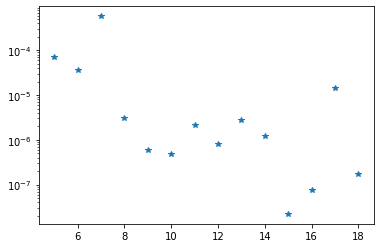

In [19]:
import matplotlib.pyplot as plt

plt.semilogy(Ks, np.array(results_Ks), '*')
plt.show()